# -- PROJET : L'analyse  des données de la COVID-19 allant du 18/03/2020 au 21/12/2021

In [49]:
                                                         ## L'importation des bibliothèques de travail ##
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sqlite3 as sql

In [50]:
## Dans le cadre de cette analyse, j'ai décidé de travailler sur des données de la COVID. Une première partie portera sur une analyse régionale dans personnes hospitalisées ainsi que 
## des personnes admises en réanimation et décedées. L'analyse doit prendre en compte la classe d'âgesEn prenant en compte ce aspect, une deuxième analyse sera faite en prenant
#en comte l'aspect départemental.

In [51]:
                                                                ## L'importation des jeux de données ##
    
                                #source des données: https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/
## Importation des données après le téléchargement sur le site de data.gouv.fr
    
data_reg = pd.read_csv('covidhospitincidreg.csv', sep = ";", encoding = 'ISO-8859-1')               ## * Les informations par régions * ##
data_classe_age = pd.read_csv('donnees-hospitalieres-classe-age-covid19.csv', sep = ";")            ## * Une base complète par région * ##
data_cov19 = pd.read_csv('donnees-hospitalieres-covid19.csv', sep = ";")                            ## * Une base complète par département avec une différence par sexe * ##
data_nouv_hosp = pd.read_csv('donnees-hospitalieres-nouveaux-covid19.csv', sep = ";")

In [52]:
data_cov19.head()   ## La visualisation des cinq premières lignes de mon jeu de données principal

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0
3,02,0,2020-03-18,41,10,NaN,NaN,NaN,18,11
4,02,1,2020-03-18,19,4,NaN,NaN,NaN,11,6


In [53]:

                        ## La création d'un dictionnaire contenant le code de départements et le nom du département en question ##
                        ## La clé de ce dictionnaire correspond aux code départements et la clé valeur est le nom du département ##
        
regions = {1 :'Guadeloupe', 2 : 'Martinique', 3 : 'Guyane', 4 :'La Réunion', 6 : 'Mayotte', 11 : 'Ile-de-France', 24 : 'Centre-Val de Loire', 
  27 : 'Bourgogne-Franche-Comté', 28 : 'Normandie', 32 : 'Hauts-de-France', 44 : 'Grand Est', 52 : 'Pays de la Loire', 53 : 'Bretagne', 
  75 : 'Nouvelle-Aquitaine', 76 : 'Occitanie', 84 : 'Auvergne-Rhône-Alpes', 93 : 'Provence-Alpes-Côte d\'Azur', 94 : 'Corse'}

## STEP I - L'analyse de données en fonction des classes d'âge et des régions.

In [54]:
#Dans le but d'évaluer la classe de la population la plus touchée, nous analyserons les données en fonctions de ces classes. Ces dernières se catégorisent ainsi dans notre 
#base de données. 0 = tous âges, 09 = 0-9 ans, 19 = 10-19 ans, 29 = 20-29 ans, 39 = 30-39 ans, 49 = 40-49 ans, 59 = 50-59 ans, 69 = 60-69 ans, 79 = 70- 79 ans, 
#89 = 80-89 ans, 90 = 90 ans et plus.
                                                        ## La description des variables ##
    #Dans le présent jeu de données, nous avons dix variables qui sont: 
#reg : l'indentifiant de la région exemple 01, 59,35, 92...
#cl_age90: 0 = tous âges, 09 = 0-9 ans, 19 = 10-19 ans, 29 = 20-29 ans, 39 = 30-39 ans, 49 = 40-49 ans, 59 = 50-59 ans, 69 = 60-69 ans, 79 = 70- 79 ans, 89 = 80-89 ans
           #90 = 90 ans et plus.
#jour: la date de notification.
#hosp: le nombre de personnes actuellement hospitalisées.
#rea:  le nombre de personnes actuellement hospitalisées en réanimation ou en soins intensifs.
#HospConv: Nombre de personnes actuellement hospitalisées en hospitalisation conventionnelle.
#SSR_USLD: Nombre de personnes actuellement hospitalisées en service Soins de Suite et de Réadaptation (SSR) ou Unités de Soins de Longue Durée(USLD).
#autres: Nombre de personnes actuellement hospitalisées en autres types de service
#rad: Nombre cumulé de personnes retournées à domicile
#dc: Nombre cumulé de personnes décédées

In [55]:
#la transformation de la variable #jour en format date.
data_classe_age['jour'] = pd.to_datetime(data_classe_age['jour'])

In [56]:
# La statistique descriptive de notre base de données, notamment toutes les variables sauf la région, la date et la classe.
data_classe_age.iloc[:,2:10].describe()

,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
count,127512.000000,127512.000000,56034.000000,56034.000000,56034.000000,127512.000000,127512.000000
mean,162.640450,24.880882,70.352893,43.161937,2.520166,2373.505160,533.391955
std,519.331187,87.918310,212.424684,126.755152,7.365091,7190.476435,1661.214023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,3.000000,0.000000,0.000000,71.000000,1.000000
50%,16.000000,2.000000,13.000000,3.000000,0.000000,347.000000,16.000000
75%,105.000000,13.000000,54.000000,31.000000,2.000000,1741.250000,240.000000
max,13209.000000,2668.000000,4296.000000,2100.000000,120.000000,111453.000000,22128.000000


In [57]:
## Dans le cadre de notre étude, nous constatons que les hospitalisations sont d'environ 127512, et aussi le même nombre que les personnes en réanimations. Relativement aux 
## personnes hospitalisées en hospitalisation conventionnelle, elles sont aux nombres de 56034. Ce nombre est identique aux personnes qui sont dans les services SSR et USLD.
## Après cela, on peut parler également la moyenne des personnes hospitalisées qui est de 162. Et aussi les personnes en réanimation sont aux nombres de 24.88.
## A la suite de cette statistique descriptive, je vais mener une analyse générale prenant en compte l'évolution des personnes en réanimation et hospitalisées.

In [58]:
data_classe_age.head() ## La visualisation du jeu de données avec les classes d'âges.

,reg,cl_age90,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,1,0,2020-03-18,0,0,NaN,NaN,NaN,0,0
1,1,9,2020-03-18,0,0,NaN,NaN,NaN,0,0
2,1,19,2020-03-18,0,0,NaN,NaN,NaN,0,0
3,1,29,2020-03-18,0,0,NaN,NaN,NaN,0,0
4,1,39,2020-03-18,0,0,NaN,NaN,NaN,0,0


### I - L'analyse du nombre de personnes hospitalisées par tranches d'âges.

In [59]:
        ## Je vais créer une fonction qui me permet d'avoir le nombre hospitalisation par tranche d'âges et du temps. A la suite de chaque fonction, je vais merger chaque table ##
                                    ## en fonction du jour afin d'avoir une base de données unique de toutes les classes d'âge ##

def data_tranche_age(i): ## La fonction d'analyse

    data_classe_age20200318 = data_classe_age.loc[data_classe_age['cl_age90'] == i,:] ## je fais un subset en fonction de la classe d'âges.
    data_classe_age202003181 = data_classe_age20200318.groupby(['jour'], dropna=False)['hosp'].sum().reset_index().round(0)# Après un group by en fonction du jour et une somme des 
                                                                            ## des personnes hospitalisées.
    data_classe_age202003181.columns = ['jour', str('hosp')+str(i)]         ## Le changement du nom des colonnes.
    
    return data_classe_age202003181


In [60]:
                                                    ## Je vais merger toutes les bases de données. ##
                                    ## Je vais merger tous les nouveaux jeux de données en fonction des classe d'âges ##
        
data_final0 = pd.merge(data_tranche_age(0), data_tranche_age(9), on = 'jour', how = 'inner')
data_final01 = pd.merge(data_final0, data_tranche_age(19), on = 'jour', how = 'inner')
data_final02 = pd.merge(data_final01, data_tranche_age(29), on = 'jour', how = 'inner')
data_final03 = pd.merge(data_final02, data_tranche_age(39), on = 'jour', how = 'inner')
data_final04 = pd.merge(data_final03, data_tranche_age(49), on = 'jour', how = 'inner')
data_final05 = pd.merge(data_final04, data_tranche_age(59), on = 'jour', how = 'inner')
data_final06 = pd.merge(data_final05, data_tranche_age(69), on = 'jour', how = 'inner')
data_final07 = pd.merge(data_final06, data_tranche_age(79), on = 'jour', how = 'inner')
data_final09 = pd.merge(data_final07, data_tranche_age(89), on = 'jour', how = 'inner')
data_final10 = pd.merge(data_final09, data_tranche_age(90), on = 'jour', how = 'inner')
data_final = data_final10.set_index('jour')                                              #Je transforme la varaible dates en index.
data_final.describe()                                                                    # La statistique de mon nouveau jeu de données.

# Après avoir construit une nouvelle base de données en fonction des différentes hospitalisations en fonction des tranches âges, je ferai la statistique descriptive de cette 
# base. Ensuite, je pourrai faire une représentation graphique afin de voir l'évolution du nombre des personnes hospitalisées en fonction de la date.

,hosp0,hosp9,hosp19,hosp29,hosp39,hosp49,hosp59,hosp69,hosp79,hosp89,hosp90
count,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.00000,644.000000,644.000000,644.000000
mean,16163.555901,44.897516,57.427019,193.708075,382.305901,727.597826,1611.681677,2823.11646,3801.729814,4329.274845,2067.513975
std,9314.744526,23.011635,22.378046,81.066119,190.644176,414.250525,912.796124,1569.40033,2252.840404,2870.625025,1413.649249
min,2972.000000,10.000000,16.000000,50.000000,112.000000,201.000000,407.000000,584.00000,685.000000,609.000000,217.000000
25%,7362.500000,29.000000,38.000000,115.000000,228.000000,394.750000,850.000000,1420.75000,1685.250000,1684.500000,753.750000
50%,12488.000000,39.000000,60.000000,186.000000,349.500000,649.000000,1512.500000,2258.50000,2981.000000,3127.500000,1473.000000
75%,25452.750000,52.000000,74.000000,259.250000,502.500000,892.500000,2064.500000,4017.25000,6132.000000,7258.250000,3247.750000
max,33466.000000,145.000000,106.000000,390.000000,930.000000,2016.000000,4250.000000,6252.00000,8285.000000,10320.000000,4780.000000


In [61]:
                                ## La moyenne des personnes hospitalisées qui est élévée est la tranche des personnes entre 80 à 89 ##

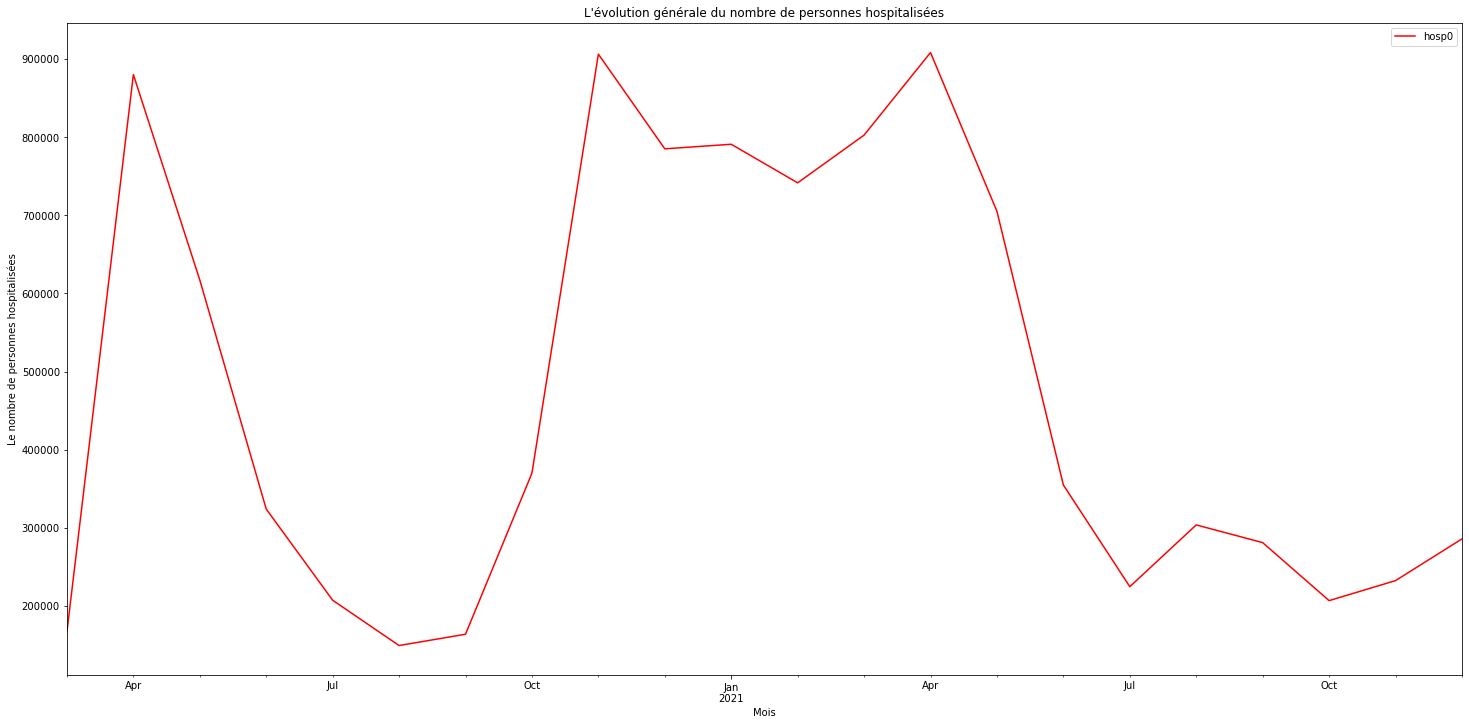

In [62]:
plt.rcParams["figure.figsize"] = [25,12]
data_final.loc['2020':'2021', 'hosp0'].resample('M').sum().plot(legend = True, color = 'red')
plt.title('L\'évolution générale du nombre de personnes hospitalisées',y=1)
plt.xlabel('Mois')
plt.ylabel('Le nombre de personnes hospitalisées')
plt.draw()
## Cette courbe est l'évolution générale des personnes hospitalisées en fonction du temps peu importe leurs classes d'âges.

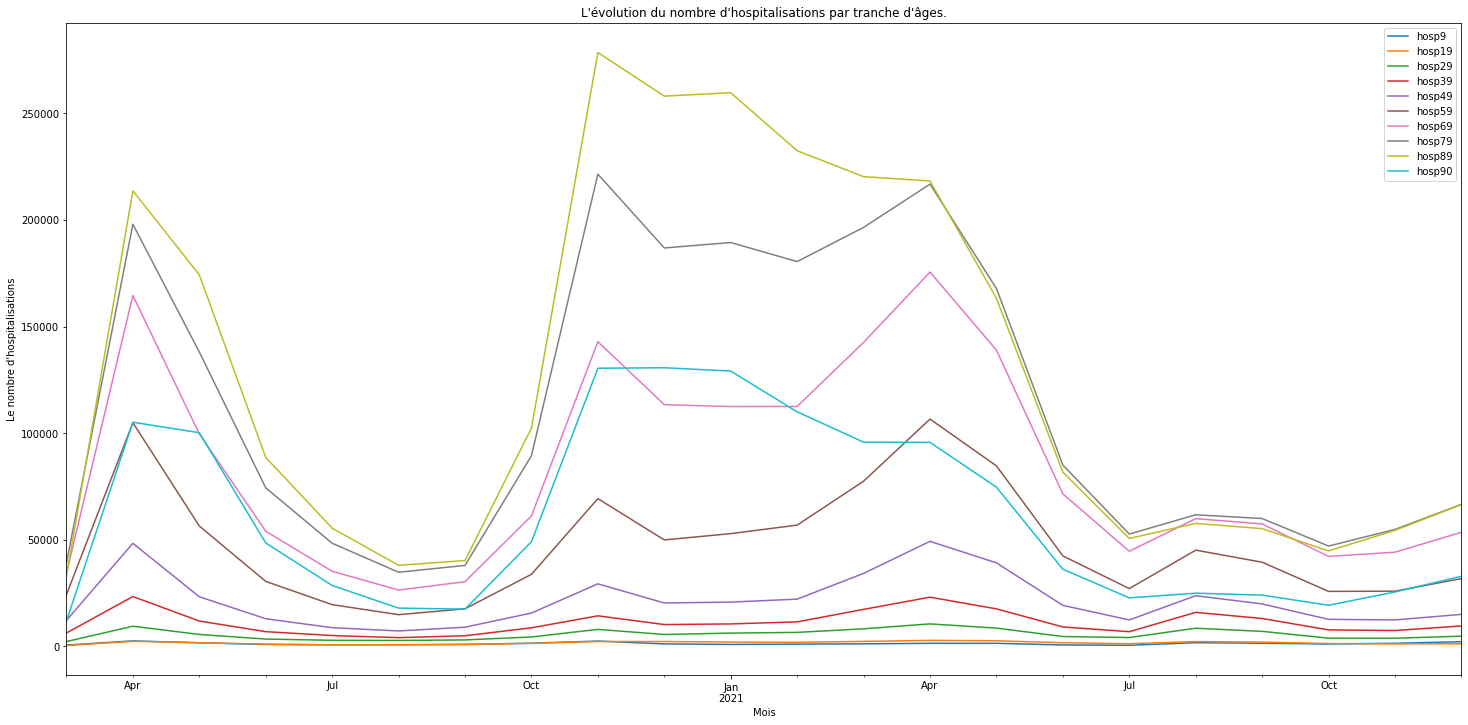

In [63]:
plt.rcParams["figure.figsize"] = [25,12]
data_final.loc['2020':'2021', 'hosp9'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp19'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp29'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp39'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp49'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp59'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp69'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp79'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp89'].resample('M').sum().plot(legend = True)
data_final.loc['2020':'2021', 'hosp90'].resample('M').sum().plot(legend = True)
plt.xlabel("Mois")
plt.ylabel("Le nombre d\'hospitalisations", y = 0.5)
plt.title("L\'évolution du nombre d'hospitalisations par tranche d'âges.", y=1)
plt.draw()
## Ces courbes me permettent d'avoir l'évolution des personnes hospitalisées sans tenir compte du département.

In [64]:
                ## Durant la période de notre étude, nous allons calculer le nombre de personnes hospitalisées en fonction de la classe d'âges ##

In [65]:
data_final101 = data_final10.iloc[:,2:12]

trans1 = ['0-9 ans','10-19 ans','20-29 ans','30-39 ans','40-49 ans','50-59 ans','60-69 ans','70- 79 ans','80-89 ans','90 ans et plus']
trans2 = list(data_final101.columns)

tran_age = []
nombre_hosp = []

for i in range(len(trans1)):
    
    tran_age.append(trans1[i])
    nombre_hosp.append(sum(list(data_final101[trans2[i]])))
    
    
data_f = pd.DataFrame()
data_f['trancheage'] = tran_age
data_f['nombrehospitalisation'] = nombre_hosp
data_f1 = data_f.set_index('trancheage')

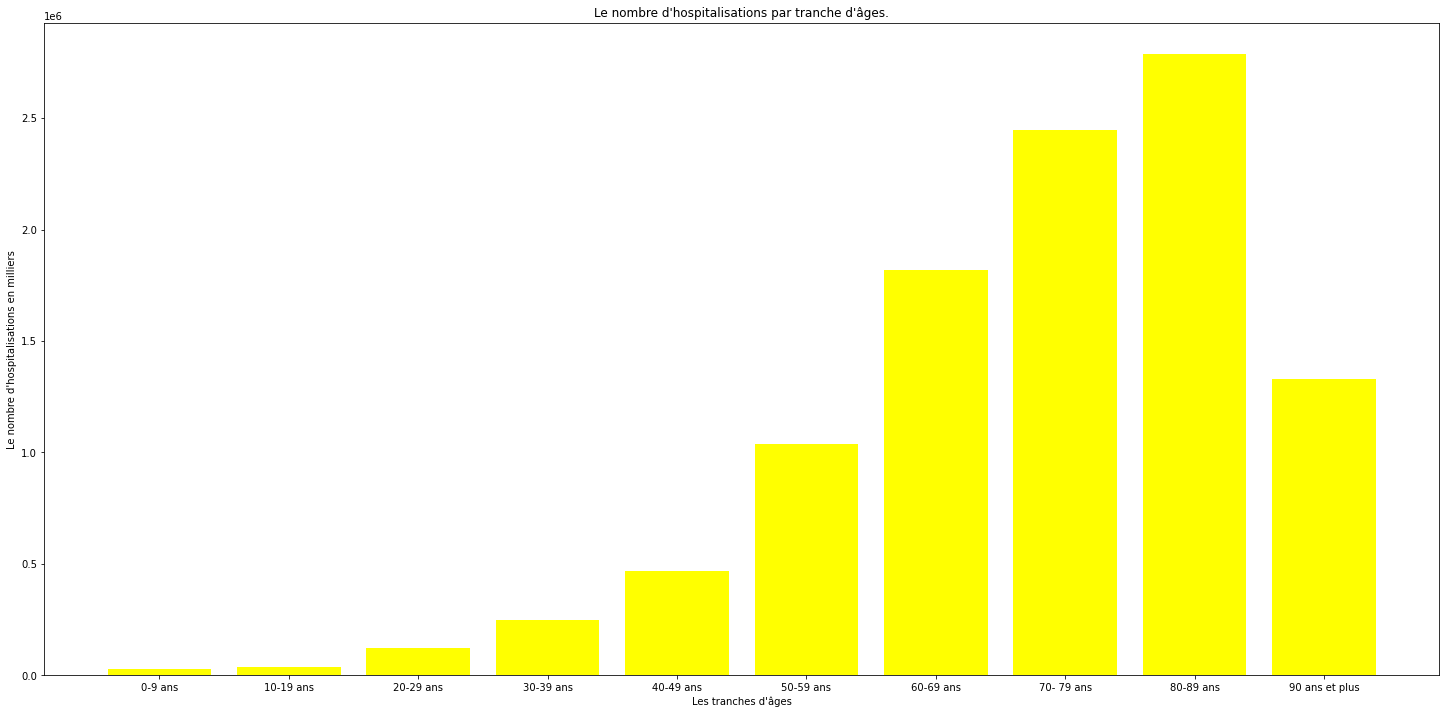

In [66]:
plt.bar(data_f1.index, data_f1['nombrehospitalisation'], color =  'yellow')
plt.xlabel("Les tranches d\'âges")
plt.ylabel("Le nombre d\'hospitalisations en milliers", y = 0.5)
plt.title("Le nombre d'hospitalisations par tranche d'âges.", y=1)
plt.draw()

### II - L'analyse du nombre de personnes en réanimation par tranches d'âges.

In [67]:
data_classe_age.head()

,reg,cl_age90,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,1,0,2020-03-18,0,0,NaN,NaN,NaN,0,0
1,1,9,2020-03-18,0,0,NaN,NaN,NaN,0,0
2,1,19,2020-03-18,0,0,NaN,NaN,NaN,0,0
3,1,29,2020-03-18,0,0,NaN,NaN,NaN,0,0
4,1,39,2020-03-18,0,0,NaN,NaN,NaN,0,0


In [68]:
def rea_tranche(k):
    
    data_classe_age_1 = data_classe_age.groupby(['jour','cl_age90'])['rea'].agg('sum').reset_index().round(0) ## Je fais un group by en fonction de la classe d'âge et du jour. Ensuite
                                                                                            ## Je fais un group by sur la classe et le jour.
    data = data_classe_age_1.loc[data_classe_age_1['cl_age90'] == k,:]
    data1 = data.rename(columns = {'rea' : data_classe_age.columns[4]+str(k)})
    data12 = data1.iloc[:,[0,2]]
    
    return data12

In [69]:
                                            ## Je vais merger toutes les bases de données issues des classes d'âges ##

data_v0 = pd.merge(rea_tranche(9), rea_tranche(19), on = 'jour', how = 'inner') # Je merge mes différentes bases de données
data_v01 = pd.merge(data_v0, rea_tranche(29), on = 'jour', how = 'inner')
data_v02 = pd.merge(data_v01, rea_tranche(39), on = 'jour', how = 'inner')
data_v03 = pd.merge(data_v02, rea_tranche(49), on = 'jour', how = 'inner')
data_v04 = pd.merge(data_v03, rea_tranche(59), on = 'jour', how = 'inner')
data_v05 = pd.merge(data_v04, rea_tranche(69), on = 'jour', how = 'inner')
data_v06 = pd.merge(data_v05, rea_tranche(79), on = 'jour', how = 'inner')
data_v07 = pd.merge(data_v06, rea_tranche(89), on = 'jour', how = 'inner')
data_v08 = pd.merge(data_v07, rea_tranche(90), on = 'jour', how = 'inner')
data_final_rea = data_v08.set_index('jour')                                     # Je transforme mes jours en index.

In [70]:
data_final_rea.describe()                                                       ## La statistique descriptive de mon nouveau jeu de données

,rea9,rea19,rea29,rea39,rea49,rea59,rea69,rea79,rea89,rea90
count,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000
mean,7.422360,7.795031,27.953416,78.829193,182.069876,443.083851,785.698758,737.177019,166.961180,17.419255
std,5.363189,5.217947,16.674013,51.022534,129.839762,322.349717,555.696292,527.895805,117.069452,11.401809
min,1.000000,0.000000,3.000000,11.000000,15.000000,45.000000,102.000000,94.000000,33.000000,1.000000
25%,4.000000,4.000000,15.000000,41.000000,95.000000,204.000000,333.000000,269.000000,57.000000,7.000000
50%,6.000000,7.000000,24.000000,65.000000,151.500000,374.000000,652.500000,551.000000,123.000000,15.000000
75%,9.000000,11.000000,39.250000,111.250000,239.000000,558.500000,1079.000000,1145.250000,285.000000,27.000000
max,30.000000,26.000000,69.000000,234.000000,588.000000,1532.000000,2320.000000,1893.000000,462.000000,45.000000


In [71]:
                                                        ## L'évolution générale des personnes en réanimation ##

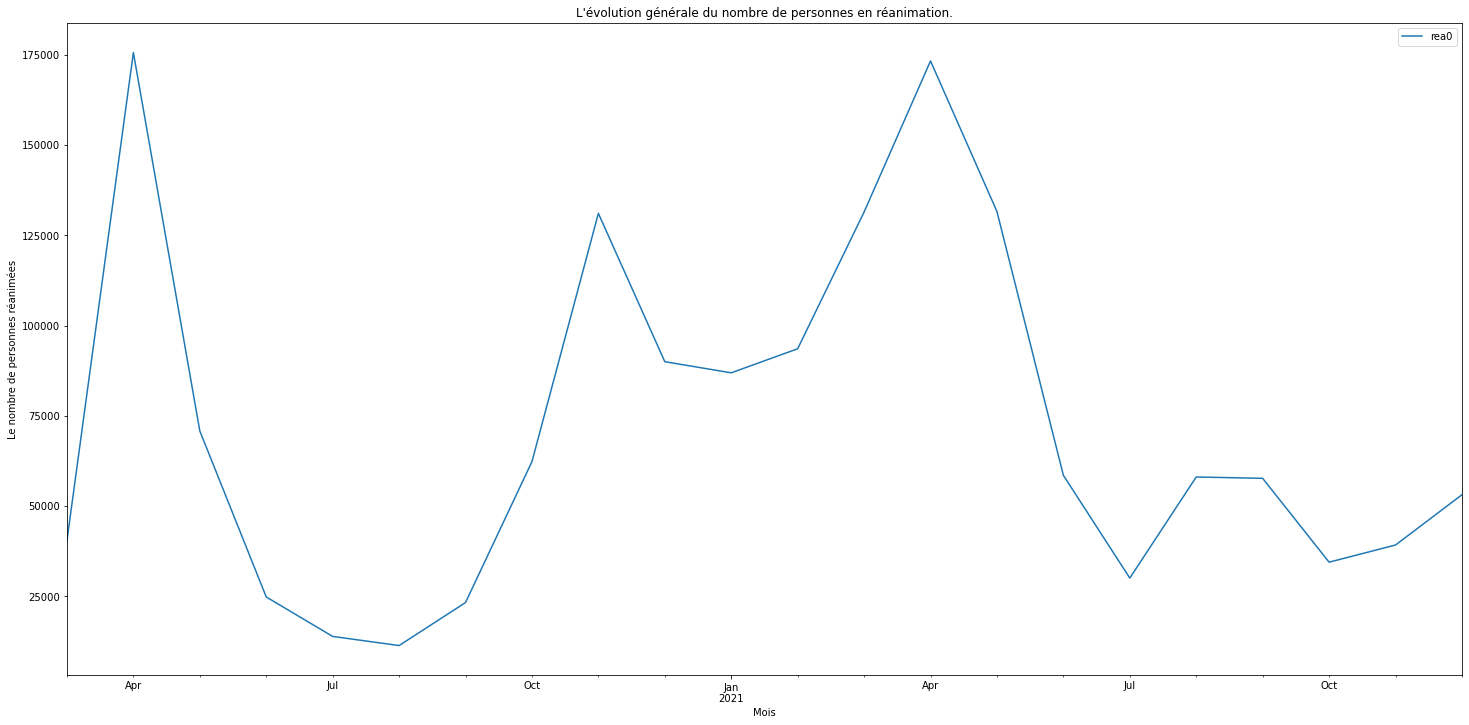

In [72]:
rea01 = rea_tranche(0).set_index('jour')
plt.rcParams["figure.figsize"] = [25,12]
rea01.loc['2020':'2021', 'rea0'].resample('M').sum().plot(legend = True)
plt.xlabel("Mois")
plt.ylabel("Le nombre de personnes réanimées", y = 0.5)
plt.title("L\'évolution générale du nombre de personnes en réanimation.", y=1)
plt.draw()
## Cette représentation me permet d'avoir l'évolution générale des personnes hospitalisées peu importe la classe d'âges

In [73]:
                                                        ## L'évolution des personnes en réanimation par tranche d'âges ##

In [74]:
def graphique_rea (k):
    
    plt.rcParams["figure.figsize"] = [25,12]
    data_final_rea.loc['2020':'2021', data_final_rea.columns[k]].resample('M').sum().plot(legend = True)
    plt.xlabel("Mois")
    plt.ylabel("Le nombre de personnes réanimées", y = 0.5)
    plt.title("L\'évolution du nombre de personnes en réanimation par tranche d'âges.", y=1)
    plt.draw()
    

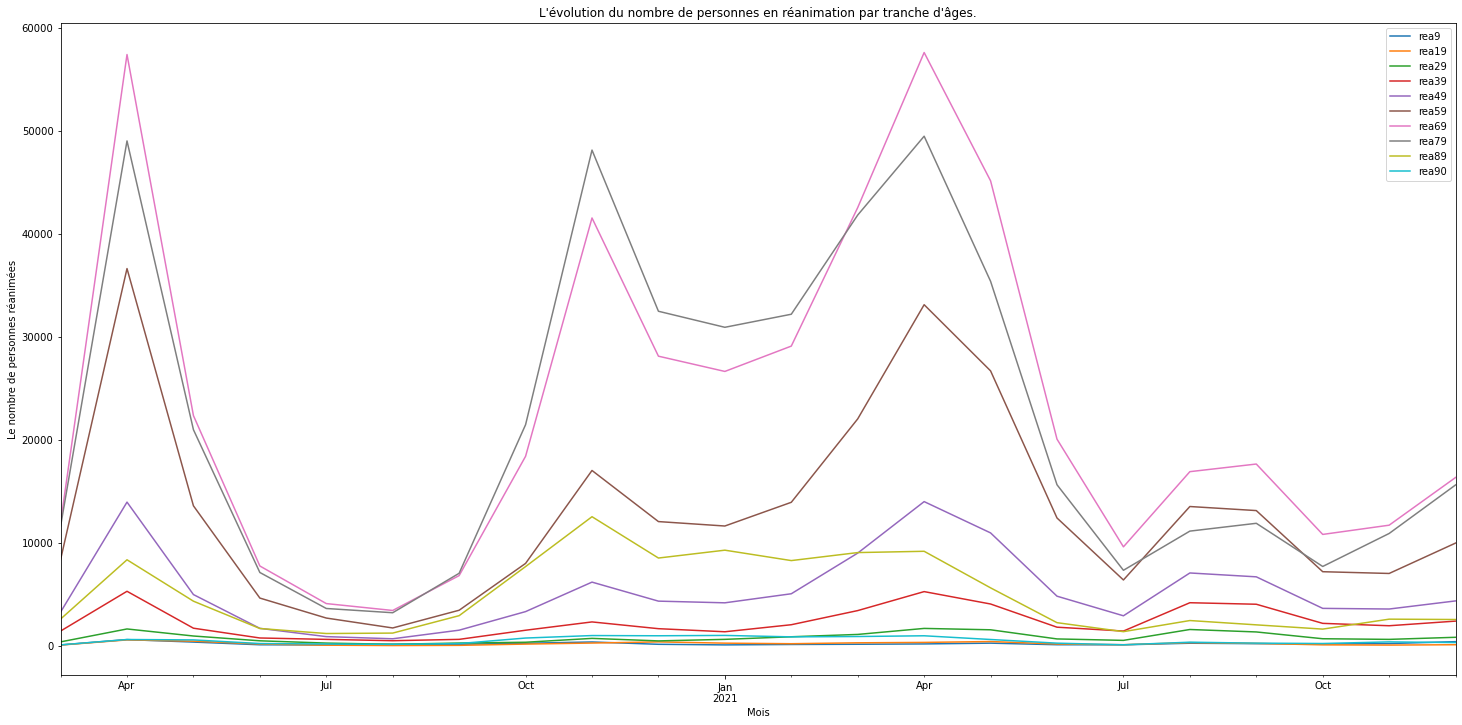

In [75]:
                                ## La représentation graphique des personnes en réanination par tranche d'âges ##
    
for i in range(10):  
    
    graphique_rea(i)

# Nous constatons selon les graphiques, les personnes agées de 60 à 69 sont les plus en réanimation.

In [76]:
                                ## Cette boucle me permet de créer un dataframe afin de visualiser le nombre de réanimer par classes d'âges

trans1 = ['0-9 ans','10-19 ans','20-29 ans','30-39 ans','40-49 ans','50-59 ans','60-69 ans','70- 79 ans','80-89 ans','90 ans et plus']

tran_age = []
number_rea = []

for k in range(len(data_final_rea.columns)):
    
    tran_age.append(trans1[k])
    number_rea.append(sum(list(data_final_rea[data_final_rea.columns[k]])))
    
    
data_rea = pd.DataFrame()
data_rea['TrancheAge'] = tran_age
data_rea['NombreReanimation'] = number_rea
data_rea1 = data_rea.set_index('TrancheAge')

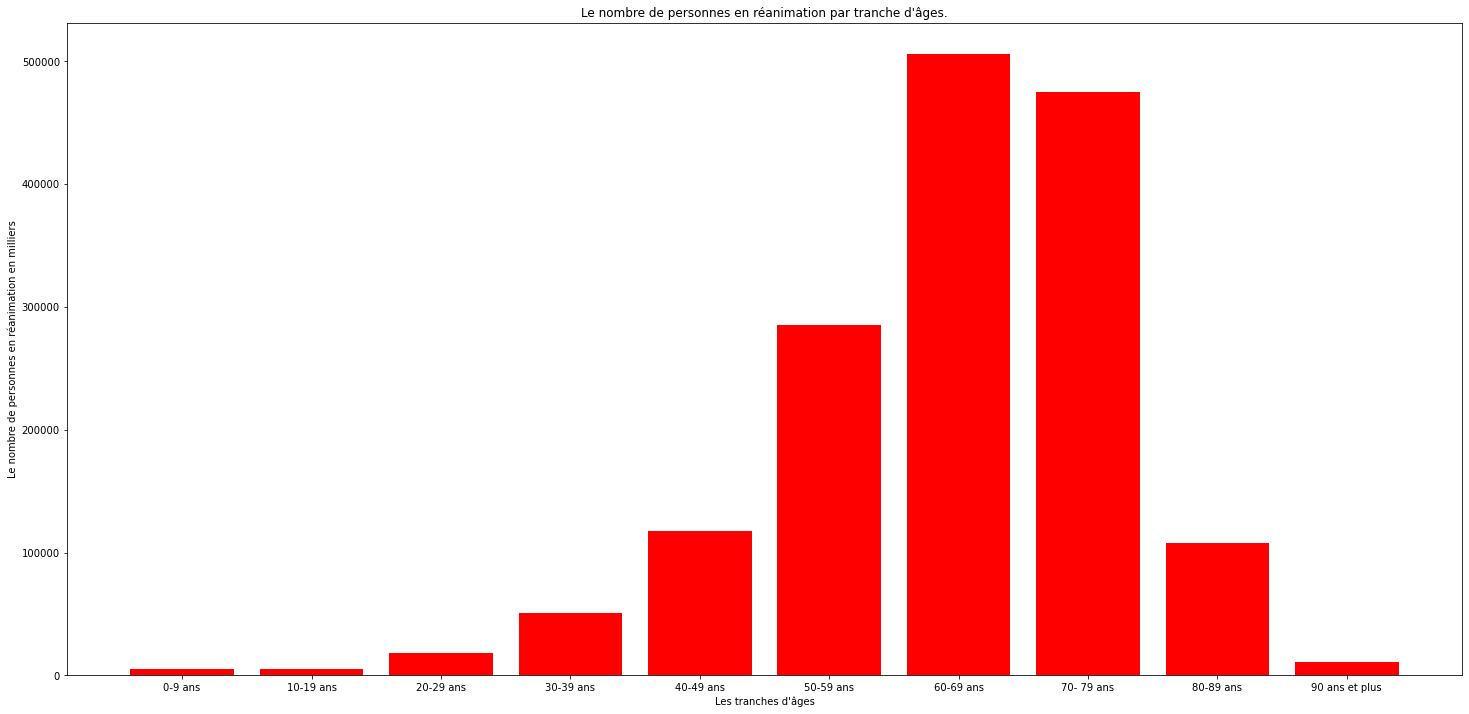

In [77]:
plt.bar(data_rea1.index, data_rea1['NombreReanimation'], color =  'red')
plt.xlabel("Les tranches d\'âges")
plt.ylabel("Le nombre de personnes en réanimation en milliers", y = 0.5)
plt.title("Le nombre de personnes en réanimation par tranche d'âges.", y=1)
plt.draw()

In [78]:
### En conclusion la première partie de notre analyse sur les tranches d'âges, nous avons decouvert des informations pertinentes. En effet, 
### relativement aux hospitalisations, la tranche d'âges la plus touchée est de 80 à 89 ans. En revanche, les personnes les plus admises en 
### réanimation sont les personnes agées de 60 à 69 et de 70 à 79 ans. Ces résultats peuvent être l'objet de recherches ou d'explications 
### épidémiologique, biologique voire médicale.

## STEP II : L'analyse des réanimations et des hospitalisations par régions.

In [79]:
                                ## La création d'un dictionnaire contenant le code et le nom des différentes régions ##
regions = {1 :'Guadeloupe', 2 : 'Martinique', 3 : 'Guyane', 4 :'La Réunion', 6 : 'Mayotte', 11 : 'Ile-de-France', 24 : 'Centre-Val de Loire', 
  27 : 'Bourgogne-Franche-Comté', 28 : 'Normandie', 32 : 'Hauts-de-France', 44 : 'Grand Est', 52 : 'Pays de la Loire', 53 : 'Bretagne', 
  75 : 'Nouvelle-Aquitaine', 76 : 'Occitanie', 84 : 'Auvergne-Rhône-Alpes', 93 : 'Provence-Alpes-Côte d\'Azur', 94 : 'Corse'}

In [80]:
data_classe_age.head()  ## La visualisation de ma base de données

,reg,cl_age90,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,1,0,2020-03-18,0,0,NaN,NaN,NaN,0,0
1,1,9,2020-03-18,0,0,NaN,NaN,NaN,0,0
2,1,19,2020-03-18,0,0,NaN,NaN,NaN,0,0
3,1,29,2020-03-18,0,0,NaN,NaN,NaN,0,0
4,1,39,2020-03-18,0,0,NaN,NaN,NaN,0,0


In [81]:
                        ## Cette fonction me permet d'avoir l'évolution des personnes hospitalisées par régions peu importe la classe d'âge ##

def regionAnalyseGenerale (i):
    
    regions = {1 :'Guadeloupe', 2 : 'Martinique', 3 : 'Guyane', 4 :'La Réunion', 6 : 'Mayotte', 11 : 'Ile-de-France', 24 : 'Centre-Val de Loire', 
      27 : 'Bourgogne-Franche-Comté', 28 : 'Normandie', 32 : 'Hauts-de-France', 44 : 'Grand Est', 52 : 'Pays de la Loire', 53 : 'Bretagne', 
      75 : 'Nouvelle-Aquitaine', 76 : 'Occitanie', 84 : 'Auvergne-Rhône-Alpes', 93 : 'Provence-Alpes-Côte d\'Azur', 94 : 'Corse'}
    #CodeRegion = list(regions.keys())
    NomRegion = list(regions.values())

    data_region_age = data_classe_age.loc[(data_classe_age['reg'] == i ) & (data_classe_age['cl_age90'] == 0), :]
    data_region_age_1 = data_region_age.groupby(['jour'])['hosp'].agg('sum').reset_index().round(0)

    data_region_age_111 = data_region_age_1.set_index('jour')
    data_region_age_111.loc['2020':'2021', 'hosp'].resample('M').sum().plot(legend = True, label = 'Tous les âges')
    plt.xlabel("Mois")
    plt.ylabel("Le nombre de personnes hospitalisées par tranche d'âges", y = 0.5)
    plt.title("L\'évolution générale du nombre de personnes hospitalisées en " + regions[i], y=1)
    plt.draw()


Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s'il vous plaît:  94


None


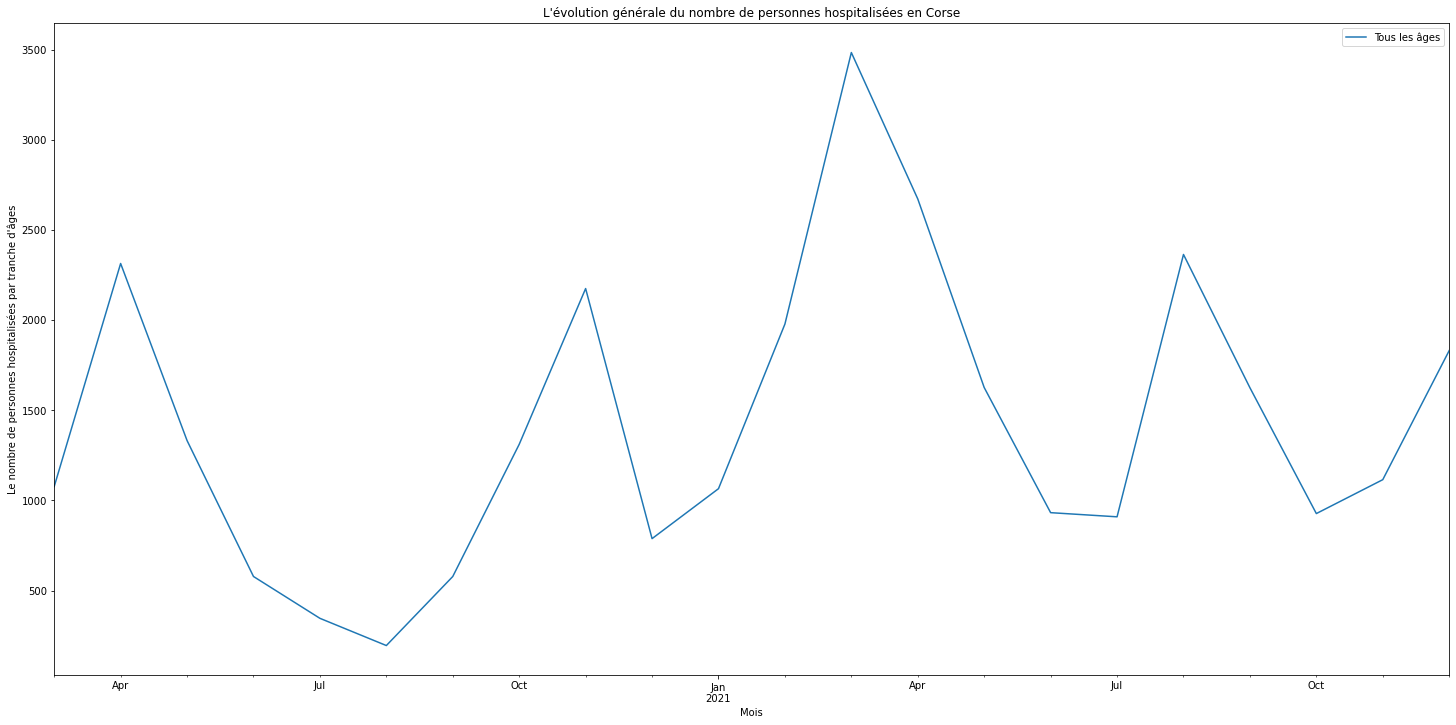

In [82]:
###### ## Je rends ma fonction dynamique en proposant à l'utilisateur d'entrer le code régional ##

codeRegion_1 = input("Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s\'il vous plaît: ")
code = int(codeRegion_1)

if (code==1 or code==2 or code==1 or code==3 or code==4 or code==6 or code==11 or code==11 or
    code==24 or code==27 or code==28 or code==32 or code==44 or code==52 or code==53 or code==75 or code==76 or code==84 or code==93 or code==94):
    
    print(regionAnalyseGenerale(code))
    
else:
    
    print('Il n\'existe pas dans la république Française une région avec ce code renseigné. Merci de rentrer un code région valide')
    

### II 1 -- L'évolution du nombre de personnes hospitalisées par région.

In [83]:
                                ## Cette fonction me permet d'avoir l'évolution des personnes hospitalisées par classes d'âges et par région ##

def regionHospAnalyse (j):
    
    regions = {1 :'Guadeloupe', 2 : 'Martinique', 3 : 'Guyane', 4 :'La Réunion', 6 : 'Mayotte', 11 : 'Ile-de-France', 24 : 'Centre-Val de Loire', 
      27 : 'Bourgogne-Franche-Comté', 28 : 'Normandie', 32 : 'Hauts-de-France', 44 : 'Grand Est', 52 : 'Pays de la Loire', 53 : 'Bretagne', 
      75 : 'Nouvelle-Aquitaine', 76 : 'Occitanie', 84 : 'Auvergne-Rhône-Alpes', 93 : 'Provence-Alpes-Côte d\'Azur', 94 : 'Corse'}
    #CodeRegion = list(regions.keys())
    NomRegion = list(regions.values())

    data_region_age = data_classe_age.loc[(data_classe_age['reg'] == j), :]
    data_region_age_1hosp = data_region_age.groupby(['jour', 'cl_age90'])['hosp'].agg('sum').reset_index().round(0)

    classe_age = [9,19,29,39,49,59,69,79,89,90]
    trans1 = ['0-9 ans','10-19 ans','20-29 ans','30-39 ans','40-49 ans','50-59 ans','60-69 ans','70- 79 ans','80-89 ans','90 ans et plus']
    
    for kj in range(len(classe_age)):
    
        data_region_age_11 = data_region_age_1hosp.loc[data_region_age_1hosp['cl_age90'] == classe_age[kj],:]
        data_region_age_111 = data_region_age_11.set_index('jour')
        data_region_age_111.loc['2020':'2021', 'hosp'].resample('M').sum().plot(legend = True, label = trans1[kj])
        plt.xlabel("Mois")
        plt.ylabel("Le nombre de personnes hospitalisées par tranche d'âges", y = 0.5)
        plt.title("L\'évolution générale du nombre de personnes hospitalisées en " + regions[j] , y=1)
        plt.draw()
        

Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s'il vous plaît:  94


None


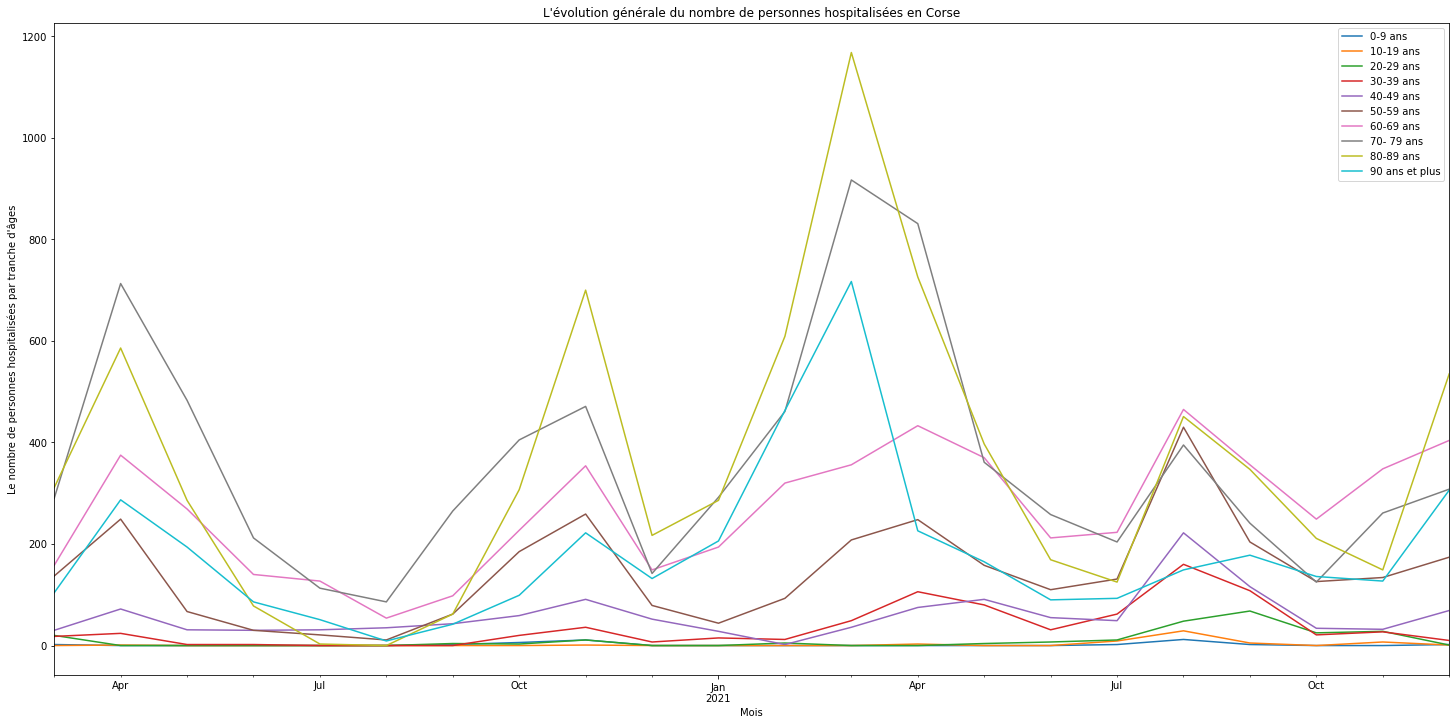

In [84]:
                                
                                            # Je rends ma fonction dynamique en proposant à l'utilisateur d'entrer le code régional ##
        
CodeRegion = list(regions.keys())
CodeRegion1 = input("Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s\'il vous plaît: ")
code = int(CodeRegion1)

if (code==1 or code==2 or code==1 or code==3 or code==4 or code==6 or code==11 or code==11 or
    code==24 or code==27 or code==28 or code==32 or code==44 or code==52 or code==53 or code==75 or code==76 or code==84 or code==93 or code==94):
    
    print(regionHospAnalyse(code))
    
else:
    
    print('Il n\'existe pas dans la république Française une région avec ce code renseigné. Merci de rentrer un code région valide')
    

### II 2 -- L'évolution du nombre de personnes réanimées par région.

In [85]:
                                            ## Identiquement à l'analyse précédente, je vais analyser les données des personnes réanimées ##

def regionReaAnalyse (j):
    
    regions = {1 :'Guadeloupe', 2 : 'Martinique', 3 : 'Guyane', 4 :'La Réunion', 6 : 'Mayotte', 11 : 'Ile-de-France', 24 : 'Centre-Val de Loire', 
      27 : 'Bourgogne-Franche-Comté', 28 : 'Normandie', 32 : 'Hauts-de-France', 44 : 'Grand Est', 52 : 'Pays de la Loire', 53 : 'Bretagne', 
      75 : 'Nouvelle-Aquitaine', 76 : 'Occitanie', 84 : 'Auvergne-Rhône-Alpes', 93 : 'Provence-Alpes-Côte d\'Azur', 94 : 'Corse'}
    #CodeRegion = list(regions.keys())
    NomRegion = list(regions.values())

    data_region_age = data_classe_age.loc[(data_classe_age['reg'] == j), :]
    data_region_age_1rea = data_region_age.groupby(['jour', 'cl_age90'])['rea'].agg('sum').reset_index().round(0)

    classe_age = [9,19,29,39,49,59,69,79,89,90]
    trans1 = ['0-9 ans','10-19 ans','20-29 ans','30-39 ans','40-49 ans','50-59 ans','60-69 ans','70- 79 ans','80-89 ans','90 ans et plus']
    
    for ku in range(len(classe_age)):
    
        data_region_age_11 = data_region_age_1rea.loc[data_region_age_1rea['cl_age90'] == classe_age[ku],:]
        data_region_age_111 = data_region_age_11.set_index('jour')
        data_region_age_111.loc['2020':'2021', 'rea'].resample('M').sum().plot(legend = True, label = trans1[ku])
        plt.xlabel("Mois")
        plt.ylabel("Le nombre de personnes reanimées par tranche d'âges", y = 0.5)
        plt.title("L\'évolution générale du nombre de personnes reanimées en " + regions[j] , y=1)
        plt.draw()
    

Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s'il vous plaît:  94


None


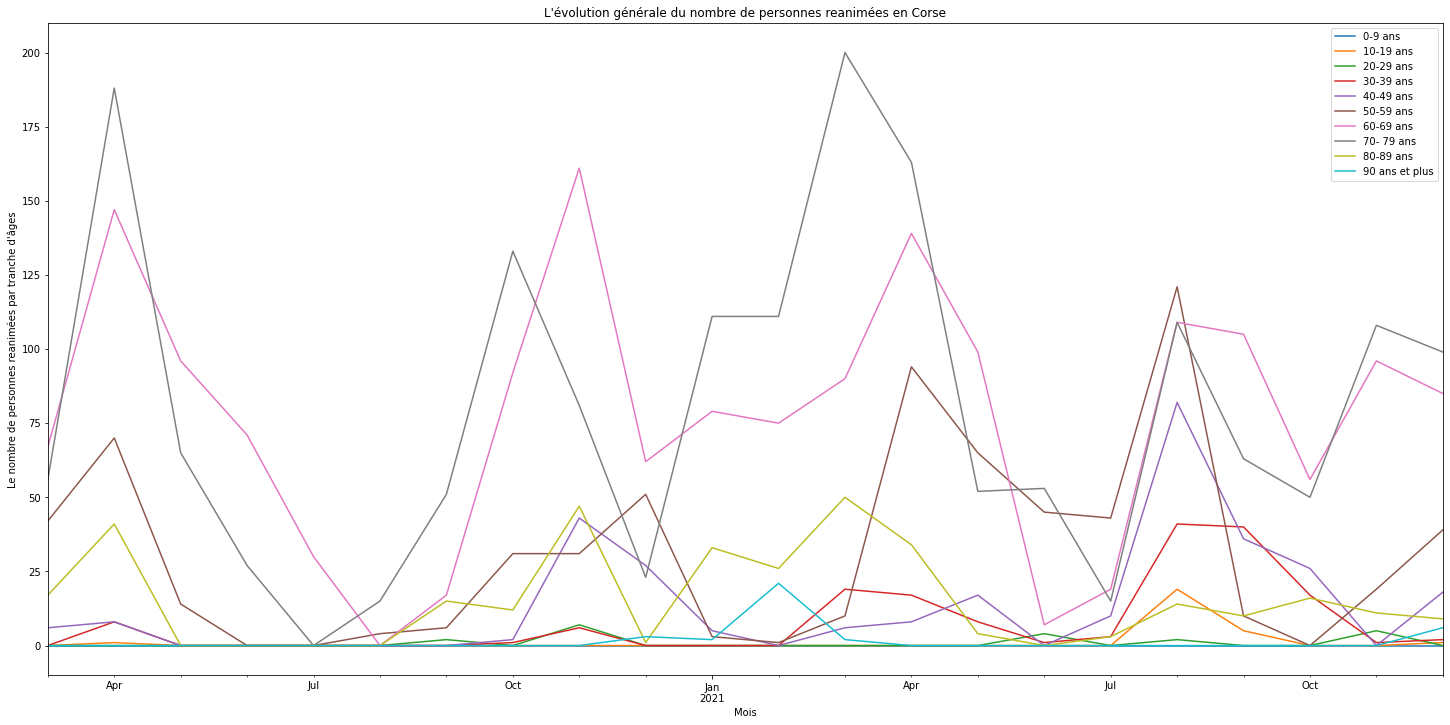

In [86]:
                                            ## Je rends la fonction dynamique en sollicitant l'utilisateur à entrer le code pays ##

CodeRegion = list(regions.keys())
CodeRegion1 = input("Bonjour Monsieur, pouvez-vous écrire l'identifiant de votre région d'analyse, s\'il vous plaît: ")
code = int(CodeRegion1)

if (code==1 or code==2 or code==1 or code==3 or code==4 or code==6 or code==11 or code==11 or
    code==24 or code==27 or code==28 or code==32 or code==44 or code==52 or code==53 or code==75 or code==76 or code==84 or code==93 or code==94):
    
    print(regionReaAnalyse(code))
    
else:
    
    print('Il n\'existe pas dans la république Française une région avec ce code renseigné. Merci de rentrer un code région valide')
    

## L'analyse des hospitalisés / des réanimés par âge et par région.

In [87]:
df_region = pd.DataFrame()
df_region['reg'] = list(regions.keys())
df_region['NomRegion'] = list(regions.values())

In [88]:
data_classe_age_Reg = pd.merge(data_classe_age, df_region, on = 'reg', how = 'left')

In [89]:
data_classe_age_Reg.head()

,reg,cl_age90,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc,NomRegion
0,1,0,2020-03-18,0,0,NaN,NaN,NaN,0,0,Guadeloupe
1,1,9,2020-03-18,0,0,NaN,NaN,NaN,0,0,Guadeloupe
2,1,19,2020-03-18,0,0,NaN,NaN,NaN,0,0,Guadeloupe
3,1,29,2020-03-18,0,0,NaN,NaN,NaN,0,0,Guadeloupe
4,1,39,2020-03-18,0,0,NaN,NaN,NaN,0,0,Guadeloupe


### -- L'analyse des personnes hospitalisées par classes d'âges et par régions.

In [90]:
def AnalyseHosp_ClasseAge_12(ki):
    
    trans_1 = {9:'0-9 ans',19:'10-19 ans',29:'20-29 ans',39:'30-39 ans',49:'40-49 ans',59:'50-59 ans',69:'60-69 ans',79:'70- 79 ans',89:'80-89 ans',
          90:'90 ans et plus'}
    
    data_classe_age_Reg_hosp = data_classe_age_Reg.loc[data_classe_age_Reg['cl_age90'] == ki, :]
    data_classe_age_Reg_hosp1 = data_classe_age_Reg_hosp.groupby('NomRegion')['hosp'].agg('sum').reset_index().round(0)
    data_classe_age_Reg_hosp1 = data_classe_age_Reg_hosp1.set_index('NomRegion')
    data_classe_age_Reg_hosp1 = data_classe_age_Reg_hosp1.sort_values('hosp')

    plt.bar(data_classe_age_Reg_hosp1.index, data_classe_age_Reg_hosp1['hosp'], color = 'blue')
    plt.xlabel('Les régions')
    plt.ylabel('Le nombre de personnes hospitalisées en milliers')
    plt.title('Le nombre national de personnes agées de ' + trans_1[ki] + ' hospitalisées pour la COVID par région')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()
    

Bonjour Monsieur, pouvez-vous rentrer l'âge d'analayse par région, s'il vous plaît:  79


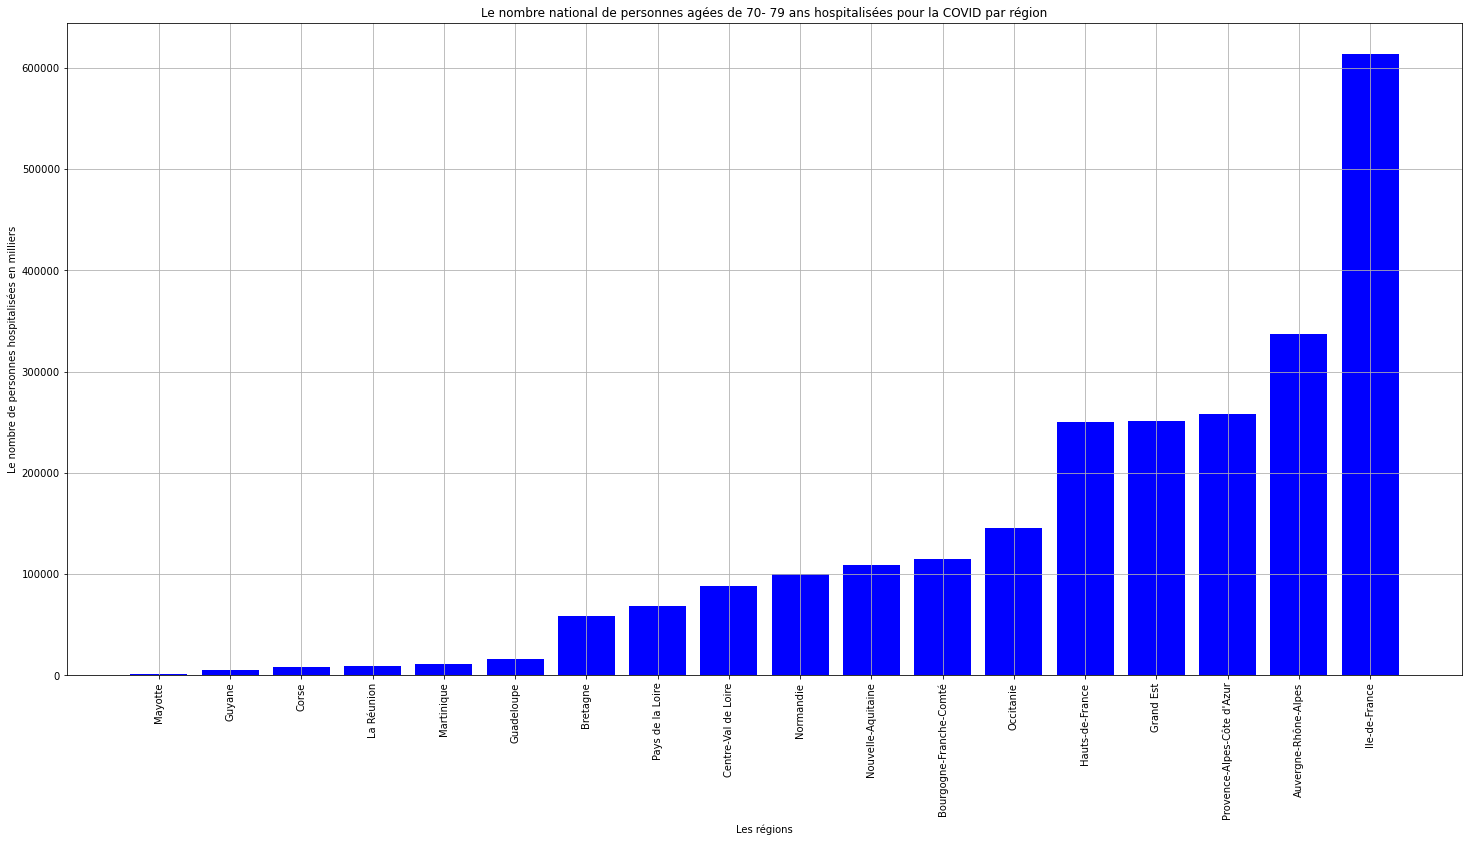

None


In [91]:
age_1 = input("Bonjour Monsieur, pouvez-vous rentrer l\'âge d\'analayse par région, s\'il vous plaît: ")
age_1i = int(age_1)

if (age_1i==9 or age_1i==19 or age_1i==29 or age_1i==39 or age_1i==49 or age_1i==59 or age_1i==69 or age_1i==79  or age_1i==89 or age_1i==90):
    
    print(AnalyseHosp_ClasseAge_12(age_1i))
    
else:
    
    print('Cette plage d\'âge n\'existe pas, il faut rentrer l\'une des valeurs suivantes:9,19,29,39,49,59,69,79,89,90')
    

### -- L'analyse du nombre de personnes réanimées par classe d'âges et par région.

In [92]:
def AnalyseRea_ClasseAge_12(kr):

    trans_1 = {9:'0-9 ans',19:'10-19 ans',29:'20-29 ans',39:'30-39 ans',49:'40-49 ans',59:'50-59 ans',69:'60-69 ans',79:'70- 79 ans',89:'80-89 ans',
          90:'90 ans et plus'}
    
    data_classe_age_Reg_rea = data_classe_age_Reg.loc[data_classe_age_Reg['cl_age90'] == kr, :]
    data_classe_age_Reg_rea1 = data_classe_age_Reg_rea.groupby('NomRegion')['rea'].agg('sum').reset_index().round(0)
    data_classe_age_Reg_rea1 = data_classe_age_Reg_rea1.set_index('NomRegion')
    data_classe_age_Reg_rea1 = data_classe_age_Reg_rea1.sort_values('rea')

    plt.bar(data_classe_age_Reg_rea1.index, data_classe_age_Reg_rea1['rea'], color = 'green')
    plt.xlabel('Les régions')
    plt.ylabel('Le nombre de personnes hospitalisées en milliers')
    plt.title('Le nombre national de personnes agées de ' + trans_1[kr] + ' en réanimation par la COVID par région')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()
    
#+ trans_1[ki]

Bonjour Monsieur, pouvez-vous rentrer l'âge d'analayse, s'il vous plaît:  89


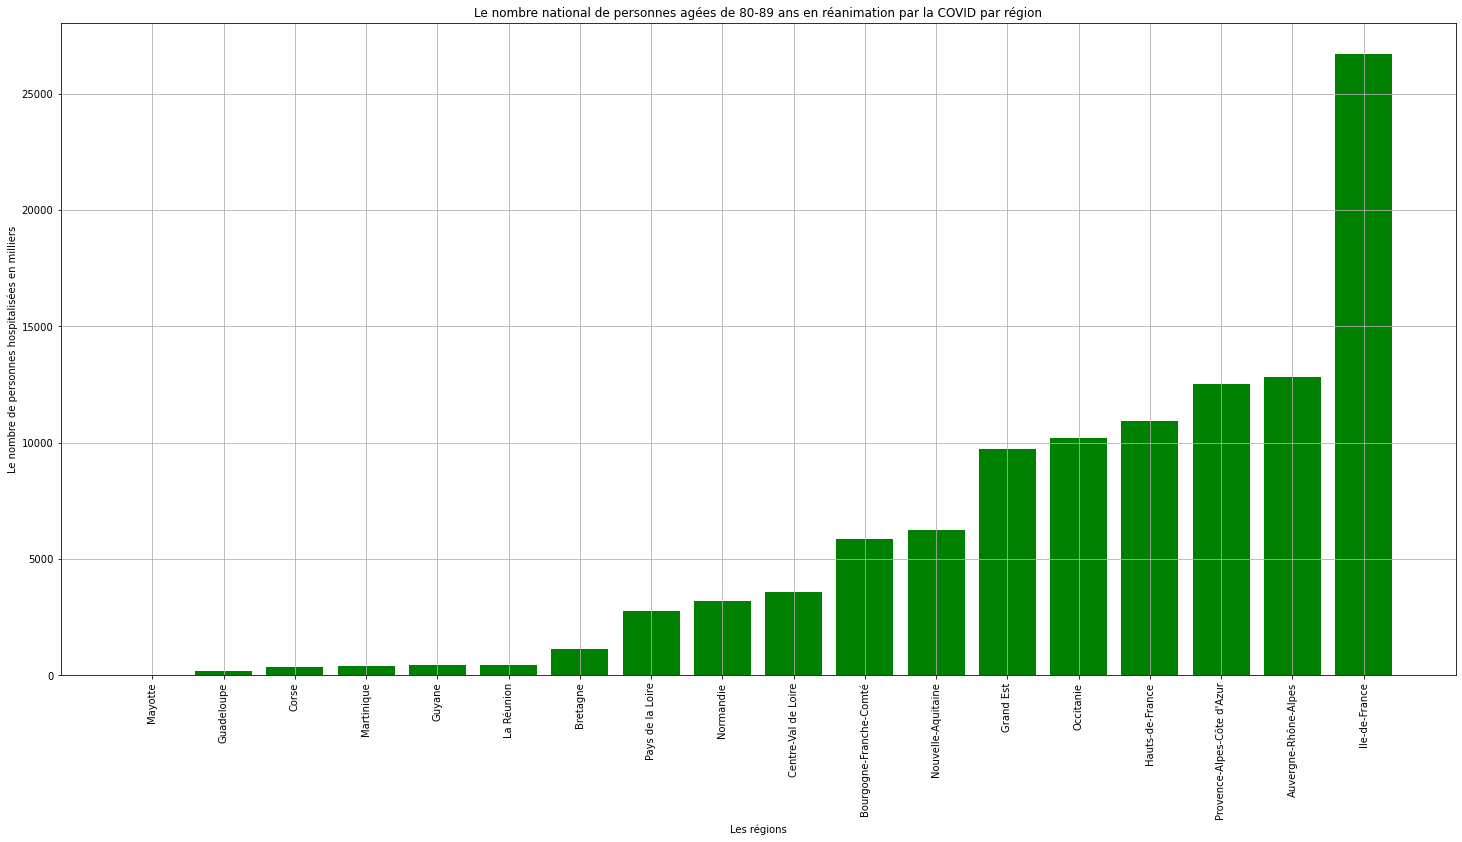

None


In [93]:
age_1r = input("Bonjour Monsieur, pouvez-vous rentrer l\'âge d\'analayse, s\'il vous plaît: ")
age_1i = int(age_1r)

if (age_1i==9 or age_1i==19 or age_1i==29 or age_1i==39 or age_1i==49 or age_1i==59 or age_1i==69 or age_1i==79  or age_1i==89 or age_1i==90):
    
    print(AnalyseRea_ClasseAge_12(age_1i))
    
else:
    
    print('Cette plage d\'âge n\'existe pas, il faut rentrer l\'une des valeurs suivantes:9,19,29,39,49,59,69,79,89,90')
    

## -- L'Analyse SQL

## -- La conception et l'insertion dans la base de données.

In [126]:
data_cov19.head()

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0
3,02,0,2020-03-18,41,10,NaN,NaN,NaN,18,11
4,02,1,2020-03-18,19,4,NaN,NaN,NaN,11,6


In [1094]:
            ## Je vais utiliser ce jeu de données pour créer une base de données qui comporte quatre table, notamment celles de personnes hospitalisées réanimées et décedées. ##

In [127]:
                                                            ## la création de ma base de données et des différentes tables ##

import sqlite3 

# make the database connection and cursor object
connection = sqlite3.connect("COVIDData.db")            ## Cette instruction permet la création de ma base de données.
cursorcovi = connection.cursor()                          ## La création d'un curseur qui me permettra l'éxecution de mes requêtes SQL relatives à ma base de données COVIDData1.db 

cursorcovi.executescript(""" 

    DROP TABLE IF EXISTS tablehosp;                 
    DROP TABLE IF EXISTS tablerea;
    DROP TABLE IF EXISTS tabledec;
    DROP TABLE IF EXISTS tableDep;
  
""")                                                     ## Ce bloc d'instructions me permet de supprimer des tables si elles existent déjà dans ma base de données COVIDData1.db 

cursorcovi.executescript(""" 

    CREATE TABLE tablehosp(id INTEGER PRIMARY KEY
    UNIQUE, datehosp DATE, IdDepT VARCHAR(4),
    FemaleHosp INTEGER, MaleHosp INTEGER, TotalHosp INTEGER);
  
""")                                                    ## Ce bloc d'instructions me permet de créer la table tablehosp concernant le nombre de personnes hospitalisées.

cursorcovi.executescript(""" 

    CREATE TABLE tablerea(id INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE, dateRea,IdDepT VARCHAR(4),
    FemaleRea INTEGER, MaleRea INTEGER, TotalRea INTEGER);
    
    
  
""")                                                   ## Ce bloc d'instructions me permet de créer la table tablehosp concernant le nombre de personnes en réanimation.

cursorcovi.executescript(""" 

    CREATE TABLE tabledec(id INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE, dateDec DATE,IdDepT VARCHAR(4),
    FemaleDec INTEGER, MaleDec INTEGER, TotalDec INTEGER);
    
    
  
""")                                                  ## Ce bloc d'instructions me permet de créer la table tablehosp concernant le nombre de personnes décedées.

cursorcovi.executescript(""" 

    CREATE TABLE tableDep (IdDep VARCHAR(4) PRIMARY KEY, NomDep TEXT, 
    Superficie FLOAT, Longitude FLOAT, Latitude FLOAT); 
    
  
""")                                                  ## Ce bloc d'instructions me permet de créer la table tableDep concernant les différents départements et leurs 
                                                      ## caractéristiques.

## Au moment de la création de ma base de données, j'ai crée des clés primaires. ##
## A la suite de cela, je vais crée des clés étrangères dans les tables d'hospitalisations, de réanimations et de décès ##

In [128]:

                                                                ## L'insertion des données dans la table tableDep ##

cursorcovi.executescript(""" 

INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('01', 'AIN',                    5785, 5.20, 46.05);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('02', 'AISNE',                  7419, 3.33, 49.33);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('03','ALLIER',                  7380, 3.11, 46.23);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('04', 'ALPES-DE-HAUTE-PROVENCE',6996, 6.14, 44.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('05', 'HAUTES-ALPES',           5689, 6.15, 44.39);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('06', 'ALPES-MARITIMES',        4297, 7.06, 43.56);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('07', 'ARDECHE',                5565, 4.25, 44.45);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('08','ARDENNES',                5244, 4.38, 49.36);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('09', 'ARIEGE',                 4908, 1.30, 42.55);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('10','AUBE',                    6027, 4.09, 48.18);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('11','AUDE',                    6345,2.24, 43.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('12','AVEYRON',                 8774, 2.40,44.16);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('13', 'BOUCHES-DU-RHONE',       5247, 5.05, 43.32);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('14','CALVADOS',                5606, 21.49,49.05);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('15', 'CANTAL',                 5776, 2.40,45.03);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('16','CHARENTE',                5974, 0.12, 45.43);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('17', 'CHARENTE-MARITIME',      6914, 0.40, 45.46);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('18', 'CHER',                   7310, 2.29, 47.03);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('19', 'CORREZE',                5900, 1.52,45.21);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('2A','CORSE-DU-SUD',            4022, 8.59,41.51);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('2B', 'HAUTE-CORSE',            4708, 9.12, 42.23);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('21', 'COTE-D-OR',              8803, 4.46, 47.25);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('22','COTES-D-ARMOR',           6983, 2.51, 48.26);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('23', 'CREUSE',                 5599, 2.01, 46.05);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('24','DORDOGNE',                9224, 0.44, 45.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('25','DOUBS',                   5254,6.21, 47.09);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('26','DROME',                   6559, 5.10, 44.41);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('27', 'EURE',                   6035, 0.59,49.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('28', 'EURE-ET-LOIR',           5933, 1.22,48.23);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('29', 'FINISTERE',              6759, 4.03, 48.15);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('30','GARD',                    5876,4.10,43.59);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('31', 'HAUTE-GARONNE',          6360,1.10,43.21);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('32','GERS',                    6300, 0.27, 43.41);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('33', 'GIRONDE',                10155,0.34,44.49);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('34', 'HERAULT',                6231,3.22,43.34);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('35', 'ILLE-ET-VILAINE',        6844,1.38,48.09);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('36', 'INDRE',                  6898, 1.34,46.46);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('37', 'INDRE-ET-LOIRE',         6160, 0.41, 47.15);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('38', 'ISERE',                  7876, 5.34, 45.15);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('39', 'JURA',                   5050, 5.41,46.43);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('40', 'LANDES',                 9351, 0.47,43.57);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('41', 'LOIR-ET-CHER',           6419,1.25,47.37);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('42', 'LOIRE',                  4807, 4.09,45.43);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('43', 'HAUTE-LOIRE',            5005, 3.48,45.07);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('44', 'LOIRE-ATLANTIQUE',       6912,1.40,47.21);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('45', 'LOIRET',                 6811,2.20,47.54);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('46', 'LOT',                    5227,1.36,44.37);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('47',  'LOT-ET-GARONNE',        5385,0.27,44.22);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('48', 'LOZERE',                 5175, 3.30,44.31);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('49', 'MAINE-ET-LOIRE',         7232,0.33,47.23);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('50', 'MANCHE',                 6006, 1.19,49.04);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('51', 'MARNE',                  8191, 4.14,48.56);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('52', 'HAUTE-MARNE',            6257, 5.13,48.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('53', 'MAYENNE',                5212, 0.39,48.08);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('54', 'MEURTHE-ET-MOSELLE',     5282,6.09,48.47);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('55', 'MEUSE',                  6236, 5.22,48.59);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('56', 'MORBIHAN',               6874,2.48,47.50);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('57', 'MOSELLE',                6251,6.39,49.02);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('58', 'NIEVRE',                 6874,3.30,47.06);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('59', 'NORD',                   5751, 3.13,50.26);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('60', 'OISE',                   5890, 2.25,49.24);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('61', 'ORNE',                   6145, 0.07,48.37);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('62', 'PAS-DE-CALAIS',          6694, 2.17,50.29);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('63', 'PUY-DE-DOME',            8012, 3.08,45.43);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('64', 'PYRENEES-ATLANTIQUES',   7685,0.45,43.15);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('65', 'HAUTES-PYRENEES',        4522,0.09,43.03);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('66', 'PYRENEES-ORIENTALES',    4141,2.31,42.36);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('67', 'BAS-RHIN',               4796,7.33,48.40);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('68', 'HAUT-RHIN',              3533,7.16,47.51);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('69', 'RHONE',                  3259,4.38,45.52);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('70', 'HAUTE-SAONE',            5391, 6.05,47.38);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('71', 'SAONE-ET-LOIRE',         8616, 4.32,46.38);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('72', 'SARTHE',                 6246, 0.13, 47.59);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('73', 'SAVOIE',                 6271,6.26,45.28);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('74', 'HAUTE-SAVOIE',           4605,6.25,46.02);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('75', 'PARIS',                  105, 2.20,48.51);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('76', 'SEINE-MARITIME',         6321,1.01,49.39);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('77', 'SEINE-ET-MARNE',         5928,2.56,48.37);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('78', 'YVELINES',               2305,1.50,48.48);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('79', 'DEUX-SEVRES',            6040,0.19,46.33);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('80', 'SOMME',                  6194,2.16,49.57);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('81', 'TARN',                   5780,2.09,43.47);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('82', 'TARN-ET-GARONNE',        3729,1.16,44.05);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('83', 'VAR',                    6163,6.13,43.27);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('84', 'VAUCLUSE',               3451, 5.11,43.59);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('85', 'VENDEE',                 6774, 1.17,46.40);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('86', 'VIENNE',                 7038,0.27,46.33);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('87', 'HAUTE-VIENNE',           5560,1.14,45.53);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('88', 'VOSGES',                 5899,6.22,48.11);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('89', 'YONNE',                  7458,3.33,47.50);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('90', 'TERRITOIRE DE BELFORT',  612,6.55,47.37);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('91', 'ESSONNE',                1819,2.14,48.31);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('92', 'HAUTS-DE-SEINE',         175, 2.14,48.50);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('93', 'SEINE-SAINT-DENIS',      237,2.28,48.55);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('94', 'VAL-DE-MARNE',           246,2.28,48.46);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('95', 'VAL-D-OISE',             1253,2.07,49.04);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('971','GUADELOUPE',             1628, -61.71,16);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('972','MARTINIQUE',             1128, -61.083, 14.6);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('973','GUYANE FRANCAISE',       83846, -52.63, 5.161167);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('974','La REUNION',2512,        55.4493961, -20.8768538);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('976','MAYOTTE',                28.41, 45.21, -12.8);
INSERT INTO tableDep (IdDep, NomDep, Superficie, Longitude, Latitude) VALUES('978','SAINT-MARTIN',           53.2, -63.0667, 18.0667)

""")  

In [129]:
                                        ## Une insertion multiple dans la table TotalHosp  ##
cursorcovi.executescript(""" 

INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '94', 44, 76, 122);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '95', 25, 64, 90);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '971', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '972', 7, 9, 16);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '973', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '974', 0, 2, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-18', '976', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '01', 1, 1, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '02', 20, 23, 43);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '03', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '04', 0, 3, 3);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '05', 7, 3, 10);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '06', 11, 21, 33);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '07', 3, 6, 11);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '08', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '09', 1, 0, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '10', 1, 5, 6);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '11', 6, 12, 18);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '12', 6, 3, 9);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '13', 65, 63, 128);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '14', 1, 3, 4);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '15', 0, 3, 3);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '16', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '17', 0, 7, 7);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '18', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '19', 0, 1, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '21', 23, 30, 53);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '22', 0, 2, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '23', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '24', 1, 1, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '25', 11, 22, 33);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '26', 14, 18, 32);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '27', 0, 1, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '28', 6, 5, 11);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '29', 8, 9, 17);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '2A', 0, 1, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '2B', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '30', 0, 4, 4);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '31', 8, 18, 26);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '32', 0, 3, 3);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '33', 2, 5, 7);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '34', 23, 26, 49);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '35', 4, 12, 16);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '36', 1, 2, 3);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '37', 2, 4, 6);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '38', 10, 12, 22);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '39', 1, 1, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '40', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '41', 2, 0, 2);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '42', 15, 33, 48);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '43', 0, 1, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '44', 7, 17, 24);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '45', 3, 6, 9);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '46', 0, 0, 0);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '47', 3, 7, 10);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '48', 1, 0, 1);
INSERT INTO tablehosp (datehosp , IdDepT, FemaleHosp, MaleHosp,TotalHosp) VALUES ('2020-03-19', '49', 9, 7, 16)

""")  

In [130]:

                                                            ## L'insertion dans la table Totalrea ##
cursorcovi.executescript(""" 

INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '94', 40, 112, 152);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '95', 28, 82, 110);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '971', 1, 6, 7);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '972', 4, 6, 11);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '973', 0, 0, 0);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '974', 0, 3, 3);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-26', '976', 0, 0, 0);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '01', 1, 8, 9);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '02', 15, 20, 35);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '03', 1, 0, 2);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '04', 0, 1, 1);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '05', 3, 4, 7);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '06', 2, 19, 22);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '07', 1, 4, 9);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '08', 3, 5, 8);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '09', 0, 1, 1);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '10', 3, 10, 13);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '11', 4, 10, 14);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '12', 3, 3, 6);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '13', 36, 74, 110);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '14', 4, 17, 21);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '15', 2, 2, 4);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '16', 3, 1, 5);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '17', 4, 9, 13);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '18', 1, 3, 4);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '19', 2, 4, 6);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '21', 13, 29, 42);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '22', 2, 3, 5);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '23', 0, 2, 2);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '24', 2, 3, 5);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '25', 7, 30, 37);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '26', 6, 27, 35);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '27', 4, 6, 10);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '28', 4, 20, 25);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '29', 2, 7, 9);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '2A', 3, 9, 12);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '2B', 1, 0, 1);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '30', 1, 10, 11);
INSERT INTO tablerea (dateRea , IdDepT, FemaleRea, MaleRea,TotalRea) VALUES ('2020-03-27', '31', 9, 47, 56)

""")

In [131]:
                                                        ## L'insertion de la table tabledec

cursorcovi.executescript(""" 


INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '79', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '80', 5, 3, 8);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '81', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '82', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '83', 1, 1, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '84', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '85', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '86', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '87', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '88', 8, 13, 22);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '89', 1, 1, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '90', 10, 4, 14);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '91', 1, 3, 4);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '92', 5, 16, 21);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '93', 10, 12, 23);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '94', 6, 11, 17);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '95', 6, 12, 18);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '971', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '972', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '973', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '974', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-22', '976', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '01', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '02', 9, 21, 30);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '03', 1, 0, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '04', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '05', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '06', 5, 3, 8);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '07', 0, 2, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '08', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '09', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '10', 0, 2, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '11', 3, 7, 10);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '12', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '13', 2, 2, 4);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '14', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '15', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '16', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '17', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '18', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '19', 0, 2, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '21', 6, 7, 13);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '22', 0, 1, 1);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '23', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '24', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '25', 3, 7, 10);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '26', 4, 3, 7);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '27', 0, 0, 0);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '28', 0, 2, 2);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '29', 1, 3, 4);
INSERT INTO tabledec (dateDec , IdDepT, FemaleDec, MaleDec,TotalDec) VALUES ('2020-03-23', '2A', 4, 3, 7)


""")

#### -- L'affichage sous forme de print des tables.

In [132]:
#rows = cursorcovi.execute(" SELECT * FROM tableDep ")
cursorcovi.execute(" SELECT * FROM tableDep ")
rows = cursorcovi.fetchall()
for line in rows:
    
    print(line)
    

('01', 'AIN', 5785.0, 5.2, 46.05)
('02', 'AISNE', 7419.0, 3.33, 49.33)
('03', 'ALLIER', 7380.0, 3.11, 46.23)
('04', 'ALPES-DE-HAUTE-PROVENCE', 6996.0, 6.14, 44.06)
('05', 'HAUTES-ALPES', 5689.0, 6.15, 44.39)
('06', 'ALPES-MARITIMES', 4297.0, 7.06, 43.56)
('07', 'ARDECHE', 5565.0, 4.25, 44.45)
('08', 'ARDENNES', 5244.0, 4.38, 49.36)
('09', 'ARIEGE', 4908.0, 1.3, 42.55)
('10', 'AUBE', 6027.0, 4.09, 48.18)
('11', 'AUDE', 6345.0, 2.24, 43.06)
('12', 'AVEYRON', 8774.0, 2.4, 44.16)
('13', 'BOUCHES-DU-RHONE', 5247.0, 5.05, 43.32)
('14', 'CALVADOS', 5606.0, 21.49, 49.05)
('15', 'CANTAL', 5776.0, 2.4, 45.03)
('16', 'CHARENTE', 5974.0, 0.12, 45.43)
('17', 'CHARENTE-MARITIME', 6914.0, 0.4, 45.46)
('18', 'CHER', 7310.0, 2.29, 47.03)
('19', 'CORREZE', 5900.0, 1.52, 45.21)
('2A', 'CORSE-DU-SUD', 4022.0, 8.59, 41.51)
('2B', 'HAUTE-CORSE', 4708.0, 9.12, 42.23)
('21', 'COTE-D-OR', 8803.0, 4.46, 47.25)
('22', 'COTES-D-ARMOR', 6983.0, 2.51, 48.26)
('23', 'CREUSE', 5599.0, 2.01, 46.05)
('24', 'DORDOGNE', 

In [133]:
                                                        ## L'affichage des personnes hospitalisées en val-de-marne. ##

donne = ('94', )
cursorcovi.execute(" SELECT * FROM tablehosp  WHERE IdDepT = ?", donne);
rowsval = cursorcovi.fetchall()

for hosp in rowsval:
    
    print(hosp)

(1, '2020-03-18', '94', 44, 76, 122)


## -- L'utilisation des requêtes SQL.

In [134]:
                                        # Affichage de l'ensemble des lignes de la table des départements et de leurs caractéristiques #
    
dfdepar = pd.read_sql_query("SELECT * FROM tableDep ", connection)

dfdepar.head()

,IdDep,NomDep,Superficie,Longitude,Latitude
0,01,AIN,5785.0,5.20,46.05
1,02,AISNE,7419.0,3.33,49.33
2,03,ALLIER,7380.0,3.11,46.23
3,04,ALPES-DE-HAUTE-PROVENCE,6996.0,6.14,44.06
4,05,HAUTES-ALPES,5689.0,6.15,44.39


In [135]:
                                                        ## les informations relatives de la dataframe df ##
dfdepar.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IdDep       102 non-null    object 
 1   NomDep      102 non-null    object 
 2   Superficie  102 non-null    float64
 3   Longitude   102 non-null    float64
 4   Latitude    102 non-null    float64
dtypes: float64(3), object(2)
memory usage: 4.1+ KB


In [136]:
                                    # Affichage de l'ensemble des lignes de la table des hospitalisations et de leurs caractéristiques #
    
dfhosp = pd.read_sql_query("SELECT * FROM tablehosp ", connection)

dfhosp.head()

,id,datehosp,IdDepT,FemaleHosp,MaleHosp,TotalHosp
0,1,2020-03-18,94,44,76,122
1,2,2020-03-18,95,25,64,90
2,3,2020-03-18,971,0,0,0
3,4,2020-03-18,972,7,9,16
4,5,2020-03-18,973,0,0,0


In [137]:
                                            ## La  selection des jours où le nombre total d'hospitalisation est supérieur à 10 ## 

dfhosp10 = pd.read_sql_query("SELECT * FROM tablehosp WHERE TotalHosp > 10 ", connection)

dfhosp10.head()

,id,datehosp,IdDepT,FemaleHosp,MaleHosp,TotalHosp
0,1,2020-03-18,94,44,76,122
1,2,2020-03-18,95,25,64,90
2,4,2020-03-18,972,7,9,16
3,9,2020-03-19,02,20,23,43
4,13,2020-03-19,06,11,21,33


In [138]:
                                                    ## l'affichage de la tables de personnes en réanimation ##
    
dfrea = pd.read_sql_query(" SELECT * FROM tablerea  ", connection)

dfrea.head()

,id,dateRea,IdDepT,FemaleRea,MaleRea,TotalRea
0,1,2020-03-26,94,40,112,152
1,2,2020-03-26,95,28,82,110
2,3,2020-03-26,971,1,6,7
3,4,2020-03-26,972,4,6,11
4,5,2020-03-26,973,0,0,0


In [139]:
                                            ## La  selection de la date et le déparmtement où le nombre total de réanimation supérieur à 50 ## 

dfhosp50 = pd.read_sql_query("SELECT dateRea, IdDepT FROM tablerea WHERE TotalRea > 50 ", connection)

dfhosp50

,dateRea,IdDepT
0,2020-03-26,94
1,2020-03-26,95
2,2020-03-27,13
3,2020-03-27,31


In [140]:
                                                    ## l'affichage de la tables de personnes décedées ##
    
dfdec = pd.read_sql_query(" SELECT * FROM tabledec  ", connection)

dfdec.head()

,id,dateDec,IdDepT,FemaleDec,MaleDec,TotalDec
0,1,2020-03-22,79,1,0,1
1,2,2020-03-22,80,5,3,8
2,3,2020-03-22,81,0,1,1
3,4,2020-03-22,82,0,1,1
4,5,2020-03-22,83,1,1,2


In [141]:

                                                    ## l'affichage de la date et le département  de personnes décedées au nombre supérieur à 5##
    
dfdec5 = pd.read_sql_query(" SELECT dateDec, IdDepT, TotalDec FROM tabledec WHERE TotalDec >= 5 ", connection)

dfdec5.head()

#data_cov19H
#list(df11.to_records(index=False))


,dateDec,IdDepT,TotalDec
0,2020-03-22,80,8
1,2020-03-22,88,22
2,2020-03-22,90,14
3,2020-03-22,92,21
4,2020-03-22,93,23


### -- La fusion ou la jointure des tables en SQL sur Python.

In [142]:
                                ## Récupération d'un curseur, la jointure des tables des hospitalisations et des départements ##
    
cursorcovi = connection.cursor() 

hosp_join=pd.read_sql_query(" SELECT * FROM tablehosp LEFT JOIN tableDep ON tablehosp.IdDepT = tableDep.IdDep ",connection);

hosp_join.head()

,id,datehosp,IdDepT,FemaleHosp,MaleHosp,TotalHosp,IdDep,NomDep,Superficie,Longitude,Latitude
0,1,2020-03-18,94,44,76,122,94,VAL-DE-MARNE,246.0,2.280,48.460000
1,2,2020-03-18,95,25,64,90,95,VAL-D-OISE,1253.0,2.070,49.040000
2,3,2020-03-18,971,0,0,0,971,GUADELOUPE,1628.0,-61.710,16.000000
3,4,2020-03-18,972,7,9,16,972,MARTINIQUE,1128.0,-61.083,14.600000
4,5,2020-03-18,973,0,0,0,973,GUYANE FRANCAISE,83846.0,-52.630,5.161167


In [143]:
                                         ## Récupération d'un curseur, la jointure des tables des hospitalisations et des départements ##
    
cursorcovi = connection.cursor() 

rea_join=pd.read_sql_query(" SELECT * FROM tablerea LEFT JOIN tableDep ON tablerea.IdDepT = tableDep.IdDep ",connection);

rea_join.head()

,id,dateRea,IdDepT,FemaleRea,MaleRea,TotalRea,IdDep,NomDep,Superficie,Longitude,Latitude
0,1,2020-03-26,94,40,112,152,94,VAL-DE-MARNE,246.0,2.280,48.460000
1,2,2020-03-26,95,28,82,110,95,VAL-D-OISE,1253.0,2.070,49.040000
2,3,2020-03-26,971,1,6,7,971,GUADELOUPE,1628.0,-61.710,16.000000
3,4,2020-03-26,972,4,6,11,972,MARTINIQUE,1128.0,-61.083,14.600000
4,5,2020-03-26,973,0,0,0,973,GUYANE FRANCAISE,83846.0,-52.630,5.161167


In [144]:
                                                        ## Les insertions dans la table de décès ##
    

cursorcovi = connection.cursor() 

dec_join=pd.read_sql_query(" SELECT * FROM tabledec LEFT JOIN tableDep ON tabledec.IdDepT = tableDep.IdDep ",connection);

dec_join.head()
    

,id,dateDec,IdDepT,FemaleDec,MaleDec,TotalDec,IdDep,NomDep,Superficie,Longitude,Latitude
0,1,2020-03-22,79,1,0,1,79,DEUX-SEVRES,6040.0,0.19,46.33
1,2,2020-03-22,80,5,3,8,80,SOMME,6194.0,2.16,49.57
2,3,2020-03-22,81,0,1,1,81,TARN,5780.0,2.09,43.47
3,4,2020-03-22,82,0,1,1,82,TARN-ET-GARONNE,3729.0,1.16,44.05
4,5,2020-03-22,83,1,1,2,83,VAR,6163.0,6.13,43.27


In [145]:
                                                ## Je recupère les variables issues de la première table après jointure ##
cursorcovi = connection.cursor() 

dec_join=pd.read_sql_query(" SELECT tabledec.* FROM tabledec LEFT JOIN tableDep ON tabledec.IdDepT = tableDep.IdDep ",connection);

dec_join.head()

,id,dateDec,IdDepT,FemaleDec,MaleDec,TotalDec
0,1,2020-03-22,79,1,0,1
1,2,2020-03-22,80,5,3,8
2,3,2020-03-22,81,0,1,1
3,4,2020-03-22,82,0,1,1
4,5,2020-03-22,83,1,1,2


In [146]:


cursorcovi = connection.cursor() 

dec_join=pd.read_sql_query(" SELECT d.* FROM tabledec as d LEFT JOIN tableDep ON d.IdDepT = tableDep.IdDep ",connection);

dec_join.head()


,id,dateDec,IdDepT,FemaleDec,MaleDec,TotalDec
0,1,2020-03-22,79,1,0,1
1,2,2020-03-22,80,5,3,8
2,3,2020-03-22,81,0,1,1
3,4,2020-03-22,82,0,1,1
4,5,2020-03-22,83,1,1,2


### -- Clause Where

In [147]:

                                                    ## l'affichage des département dont le nombre de reanimés est supérieur à 100 ##
    
dfrea100 = pd.read_sql_query(" SELECT * FROM tablerea WHERE Totalrea >=100 ", connection)

dfrea100.head()

,id,dateRea,IdDepT,FemaleRea,MaleRea,TotalRea
0,1,2020-03-26,94,40,112,152
1,2,2020-03-26,95,28,82,110
2,20,2020-03-27,13,36,74,110


In [148]:
                                                    ## Le nombre de décès est égale à 8
cursorcovi = connection.cursor() 

dec_8=pd.read_sql_query(" SELECT * FROM tabledec WHERE TotalDec = 8 ",connection);

dec_8.head()

,id,dateDec,IdDepT,FemaleDec,MaleDec,TotalDec
0,2,2020-03-22,80,5,3,8
1,28,2020-03-23,06,5,3,8


### - Les opérations

In [149]:
                                                        ## la somme des personnes hospitalisées pour la COVID ##
    
df_sum = pd.read_sql_query("SELECT round(sum(Totalhosp),0) as  HOSP_SUM FROM tablehosp ",connection)

df_sum.head()

,HOSP_SUM
0,910.0


In [150]:
                                                                ## La moyenne des femmes en réanimation

df_avg = pd.read_sql_query("SELECT round(avg(FemaleRea),0) as  HOSP_SUM FROM tablerea ",connection)

df_avg.head()

,HOSP_SUM
0,6.0


In [151]:
                                                    ## Nombre de lignes qui correspond aux nombres de départements. ##
    
df_nbre = pd.read_sql_query("SELECT count(distinct(NomDep)) as nb_departement FROM tableDep ",connection)

df_nbre.head()

,nb_departement
0,102


### -- l'opération group by

In [152]:

cursorcovi.execute(" SELECT IdDepT,round(sum(TotalRea),0) FROM tablerea group by IdDepT ")
            
rows = cursorcovi.fetchall()

for resultat in rows :    
        print(resultat)

('01', 9.0)
('02', 35.0)
('03', 2.0)
('04', 1.0)
('05', 7.0)
('06', 22.0)
('07', 9.0)
('08', 8.0)
('09', 1.0)
('10', 13.0)
('11', 14.0)
('12', 6.0)
('13', 110.0)
('14', 21.0)
('15', 4.0)
('16', 5.0)
('17', 13.0)
('18', 4.0)
('19', 6.0)
('21', 42.0)
('22', 5.0)
('23', 2.0)
('24', 5.0)
('25', 37.0)
('26', 35.0)
('27', 10.0)
('28', 25.0)
('29', 9.0)
('2A', 12.0)
('2B', 1.0)
('30', 11.0)
('31', 56.0)
('94', 152.0)
('95', 110.0)
('971', 7.0)
('972', 11.0)
('973', 0.0)
('974', 3.0)
('976', 0.0)


In [153]:
df_nbredep = pd.read_sql_query(" SELECT IdDepT,round(sum(TotalRea),0) as NbreReaParDep FROM tablerea group by IdDepT ",connection)

df_nbredep.head()

,IdDepT,NbreReaParDep
0,01,9.0
1,02,35.0
2,03,2.0
3,04,1.0
4,05,7.0


### -- Restriction par having

In [154]:
                                            ## Les departements dont le nombre total est égal ou supérieur à 100 ##

df_nbredep100 = pd.read_sql_query(" SELECT IdDepT,round(sum(TotalRea),0) as NbreReaParDep FROM tablerea group by IdDepT having NbreReaParDep > 100 ",connection)

df_nbredep100.head()

,IdDepT,NbreReaParDep
0,13,110.0
1,94,152.0
2,95,110.0


In [155]:

                                                    ## Les départements avec le nombre total compris entre 100 et 200 ##

df_nbredep1002 = pd.read_sql_query(" SELECT IdDepT,round(sum(TotalRea),0) as NbreReaParDep FROM tablerea group by IdDepT having NbreReaParDep between 100 and 200 ",connection)

df_nbredep1002.head()

,IdDepT,NbreReaParDep
0,13,110.0
1,94,152.0
2,95,110.0


### Order by (Tri)

In [156]:
                                                                        ## Le tri par ordre croissant ##

dfreaor = pd.read_sql_query(" SELECT * FROM tablerea WHERE Totalrea order by TotalRea ", connection)

dfreaor.head()

,id,dateRea,IdDepT,FemaleRea,MaleRea,TotalRea
0,11,2020-03-27,04,0,1,1
1,16,2020-03-27,09,0,1,1
2,37,2020-03-27,2B,1,0,1
3,10,2020-03-27,03,1,0,2
4,29,2020-03-27,23,0,2,2


In [157]:
                                                                        ## Le tri par ordre decroissant ##

dfreaor = pd.read_sql_query(" SELECT * FROM tablerea WHERE Totalrea order by TotalRea desc ", connection)

dfreaor.head()

,id,dateRea,IdDepT,FemaleRea,MaleRea,TotalRea
0,1,2020-03-26,94,40,112,152
1,2,2020-03-26,95,28,82,110
2,20,2020-03-27,13,36,74,110
3,39,2020-03-27,31,9,47,56
4,27,2020-03-27,21,13,29,42


### -- case when

In [158]:

dfreaor = pd.read_sql_query(" SELECT TotalRea, CASE WHEN TotalRea > 50 THEN 'beaucoup en rea' WHEN TotalRea = 50 THEN 'En rea, on 50' ELSE 'Supérieur à 50' END as QText FROM tablerea  ", connection)

dfreaor.head()


,TotalRea,QText
0,152,beaucoup en rea
1,110,beaucoup en rea
2,7,Supérieur à 50
3,11,Supérieur à 50
4,0,Supérieur à 50


# -- La Cartographie

In [1127]:
                        ## Cette partie de mon projet me permettra de visualiser le nombre de personnes hospitalisées, reanimées et decédées par département ##

In [159]:
import folium

In [160]:
dfdepar = dfdepar[['IdDep','NomDep','Latitude','Longitude']]
dfdepar.columns = ['dep','NomDep','Latitude','Longitude']
dfdepar

,dep,NomDep,Latitude,Longitude
0,01,AIN,46.050000,5.200000
1,02,AISNE,49.330000,3.330000
2,03,ALLIER,46.230000,3.110000
3,04,ALPES-DE-HAUTE-PROVENCE,44.060000,6.140000
4,05,HAUTES-ALPES,44.390000,6.150000
...,...,...,...,...
97,972,MARTINIQUE,14.600000,-61.083000
98,973,GUYANE FRANCAISE,5.161167,-52.630000
99,974,La REUNION,-20.876854,55.449396
100,976,MAYOTTE,-12.800000,45.210000


In [95]:
data_cov19gouby = data_cov19.groupby('dep')['hosp','rea','dc'].sum().reset_index()

<ipython-input-95-c2dd3c840cdc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_cov19gouby = data_cov19.groupby('dep')['hosp','rea','dc'].sum().reset_index()


In [96]:
data_cov19gouby1 = pd.merge(dfdepar, data_cov19gouby, on = 'dep', how = 'inner')

In [97]:
data_cov19gouby1

,dep,NomDep,Latitude,Longitude,hosp,rea,dc
0,01,AIN,46.050000,5.200000,163120,14027,491936
1,02,AISNE,49.330000,3.330000,190413,24514,875161
2,03,ALLIER,46.230000,3.110000,90506,10606,427711
3,04,ALPES-DE-HAUTE-PROVENCE,44.060000,6.140000,82363,4780,175101
4,05,HAUTES-ALPES,44.390000,6.150000,73144,7578,189572
...,...,...,...,...,...,...,...
97,972,MARTINIQUE,14.600000,-61.083000,121474,29345,207043
98,973,GUYANE FRANCAISE,5.161167,-52.630000,76918,17648,140103
99,974,La REUNION,-20.876854,55.449396,107817,25390,176084
100,976,MAYOTTE,-12.800000,45.210000,26823,6052,97076


In [98]:
map_osm = folium.Map(location=[46.2276, 2.2137], zoom_start = 10)

In [99]:
data_cov19gouby1_locations = data_cov19gouby1[['Latitude', 'Longitude']]

In [100]:
data_cov19gouby1_location_list = data_cov19gouby1_locations.values.tolist()
data_cov19gouby1_location_list_size = len(data_cov19gouby1_location_list)

In [101]:
for point in range(0, data_cov19gouby1_location_list_size):
    
    folium.Marker(data_cov19gouby1_location_list[point], popup = data_cov19gouby1['NomDep'][point]+'\n'+str(data_cov19gouby1['hosp'][point])+' personnes hospitalisées'+'\n'+str(data_cov19gouby1['rea'][point])+' personnes reanimées'+'\n'+str(data_cov19gouby1['dc'][point])+' personnes décedées').add_to(map_osm)
    
map_osm

In [1137]:
                                                                    ## Fin ##